# 4. Geospatial Data Exploration

Authors: Yu-Sheng Lee, Jeremy Cui, Hannah MacDonald<br>
GitHub Repository: https://github.com/UC-Berkeley-I-School/project2_lee_cui_macd/<br>
Primary Dataset: [NYC OpenData Motor Vehicle Collisions - Crashes dataset](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95)

### Initial Set Up and Data Cleaning

- Drop records that do not have `location` and `on_street name`. 
- Only keep recent years data from the start of 2019


In [5]:

# standard library
import datetime
import IPython.display as display

# data analysis
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Crash Data
crash = pd.read_csv("/Users/yu-shenglee/Desktop/dev/mids-datasci200-fall24-Yusheng-Lee/Project 2/data/Motor_Vehicle_Collisions_-_Crashes_20241124.csv", 
                   dtype={'ZIP CODE':str}, 
                   parse_dates=[ 'CRASH DATE','CRASH TIME'])
crash.columns = [column.lower().replace(' ','_') for column in crash.columns]
crash['vehicle_type_code_1'] = crash['vehicle_type_code_1'].str.lower()
crash['vehicle_type_code_2'] = crash['vehicle_type_code_2'].str.lower()
crash['vehicle_type_code_3'] = crash['vehicle_type_code_3'].str.lower()
crash['vehicle_type_code_4'] = crash['vehicle_type_code_4'].str.lower()
crash['vehicle_type_code_5'] = crash['vehicle_type_code_5'].str.lower()
crash = crash.dropna(subset=['on_street_name', 'location']) # drop records where 'on_street_name' and 'location' are null
crash = crash[crash['crash_date'] > datetime.datetime(2019, 1, 1)] # Only keep the data starting from 2019

# Property Value data
properties = pd.read_csv('/Users/yu-shenglee/Desktop/dev/mids-datasci200-fall24-Yusheng-Lee/Project 2/data/Property_Valuation_and_Assessment_Data_20241126.csv')
properties.columns = [column.lower().replace(' ','_') for column in properties.columns] # Rename column names
properties = properties[properties['year'] == '2018/19'] # Only include 2018/19 data
properties = properties[[
    'bble', 'boro', 'block', 'lot', 'bldgcl',
    'taxclass', 'stories', 'fullval', 'avland','avtot',
    'staddr', 'postcode', 'period', 'year', 'borough', 
    'latitude', 'longitude', 'council_district','nta']]
properties = properties[properties['longitude'].isnull()==False] # Remove null longitude and latitude records

# Neighborhood data
nyc_neighborhoods = gpd.read_file('/Users/yu-shenglee/Desktop/dev/mids-datasci200-fall24-Yusheng-Lee/Project 2/data/nyc_neighborhoods.geojson')

# Join Crash data with Neighborhood
points = crash.apply(lambda row: Point(row.longitude, row.latitude), axis = 1)
crash = gpd.GeoDataFrame(crash, geometry=points)
crash.crs = {'init': str(nyc_neighborhoods.crs)}
crash_w_neighborhoods = gpd.sjoin(crash, nyc_neighborhoods, how='inner', predicate="within")

# Join Property Value data with neighborhood
points = properties.apply(lambda row: Point(row.longitude, row.latitude), axis = 1) # Convert longitude and latitude to Point pair in a new column points
geo_properties = gpd.GeoDataFrame(properties, geometry=points) # Convert this data frame with new column points into a GeoPandas data frame
geo_properties.crs = {'init': str(nyc_neighborhoods.crs)} # Use the same crs assumption as nyc_neighborhoods does
properties_w_neighborhoods = gpd.sjoin(geo_properties, nyc_neighborhoods, how='inner', predicate="within") # Join properties and nyc_neighborhoods based on neighborhoods


/Users/yu-shenglee/ENTER/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/c9/wtcfhbsj4_ggwscrqd_3_rpw0000gn/T/ipykernel_10017/2716527351.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  crash_w_neighborhoods = gpd.sjoin(crash, nyc_neighborhoods, how='inner', predicate="within")
/Users/yu-shenglee/ENTER/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred in

### Bar Chart

The bar chart below shows that Brooklyn had the most collisions over the past five years among the five boroughs in New York City, followed by Queens, Mahattan, Bronx, and Staten Island. Broolyn and Queens have the highest crash frequency, probably because of the following few reasons:
1. Population density: The large and densely populated areas lead to more vehicles on the road. 
    As of July 1, 2023, the population of New York City's boroughs was:
    - Brooklyn: 2,465,326
    - Queens: 2,229,379
    - Manhattan: 1,537,195
    - Bronx: 1,332,650
    - Staten Island: 443,728
2. The Road Infrastructure: The high complexity of road networks in Brooklyn and Queens, such as a mix of residential streets, major throughfares, limited highway access, and narrow intersections. This creates confusion and congestions, also likely to cause an accident.


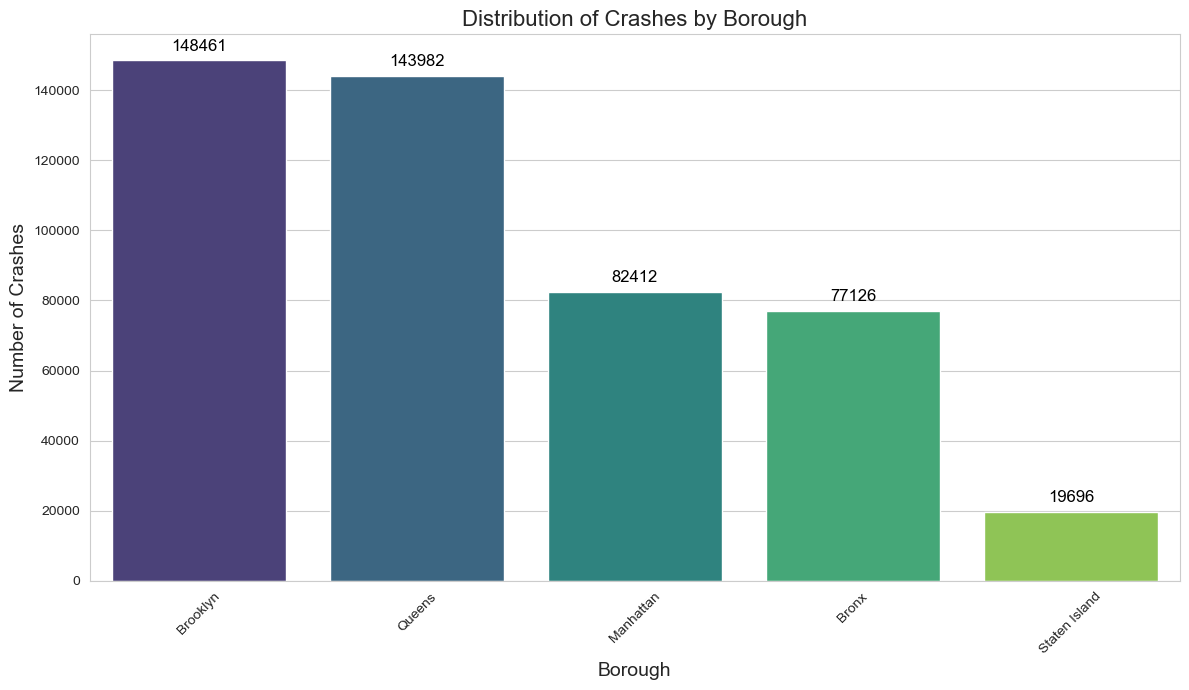

In [6]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
borough_count = crash_w_neighborhoods.groupby(by=['borough_right']).size().sort_values(ascending=False)
bar_plot = sns.barplot(x=borough_count.index, y=borough_count.values, palette="viridis")
for p in bar_plot.patches:
    bar_plot.annotate(format(int(p.get_height())), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', 
                       fontsize=12, color='black', 
                       xytext=(0, 5),  # 5 points vertical offset
                       textcoords='offset points')
plt.title('Distribution of Crashes by Borough', fontsize=16)
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Heatmap

We further plotted each data point as a heatmap onto NYC map using the Python package folium. Below, the area highlighted in green means higher concentration of collision accidents. We can see Downtown Brooklyn is one of the areas with high frequency of crashes. The other areas are somewhere in Queens. We can see somewhere in Manhattan and Bronx.

In [7]:
map = folium.Map(location=[40.730610, -73.935242], zoom_start=10)  # Create a base map and centered around NYC
heat_data = [[row['latitude'], row['longitude']] for index, row in crash_w_neighborhoods.iterrows()] # Create a heatmap
HeatMap(heat_data, radius=8, max_zoom=13).add_to(map)
map.save("image/Heatmap.html")
display.Image(url='/Users/yu-shenglee/Desktop/dev/project2_lee_cui_macd/image/Heatmap.png')

### Severity Map

We'll plot crashes on the map and code them based on severity, distinguishing between crashes that resulted in injuries and those that led to fatalities. This will give us a visual representation of where severe crashes tend to occur. Below, different shapes means:
- red triangle: fatality
- orange circle: injury
- green square: 0 injury and fatality

There are 471K data points in total. We only sample 1000 data points for cleaner visualization. 


In [8]:
# Sample a subset of the data for visualization
sample_data_severity = crash_w_neighborhoods.sample(n=1000, random_state=42)

# Create a base map
m_severity = folium.Map(location=[40.730610, -73.935242], zoom_start=10)

# Add crashes to the map with color coding and shape coding based on severity
for index, row in sample_data_severity.iterrows():
    if row['number_of_persons_killed'] > 0:
        color = "red"  # Fatalities
        folium.features.RegularPolygonMarker(
          location=[row['latitude'], row['longitude']],
          number_of_sides=3,
          radius=5,
          gradient = False,
          color=color,
          fill=True,
          fill_color=color
        ).add_to(m_severity)
    elif row['number_of_persons_injured'] > 0:
        color = "orange"  # Injuries
        folium.CircleMarker(
          location=[row['latitude'], row['longitude']],
          radius=5,
          color=color,
          fill=True,
          fill_color=color
        ).add_to(m_severity)
    else:
        color = "green"  # No injuries or fatalities
        folium.features.RegularPolygonMarker(
          location=[row['latitude'], row['longitude']],
          number_of_sides=4,
          radius=5,
          gradient = False,
          color=color,
          fill=True,
          fill_color=color
        ).add_to(m_severity)

m_severity.save("image/severity.html")

display.Image(url='image/severity.png')


From this chart, we still see high concentration in Brooklyn, Queens, and Manhattan.

### Property Value by Neighborhood 

In [ ]:
# Group Property Value by neighborhood. Only look at non zero values
properties_by_neighborhoods = properties_w_neighborhoods[['fullval', 'neighborhood']]
properties_by_neighborhoods = properties_by_neighborhoods[properties_by_neighborhoods['fullval']>0]
properties_by_neighborhoods = properties_by_neighborhoods.groupby(properties_by_neighborhoods.neighborhood)

# Merge this data set with neighborhood information using GeoPandas
average_neighborhood_val = properties_by_neighborhoods.mean().merge(nyc_neighborhoods[['neighborhood','geometry']], how = 'left', on='neighborhood')
average_neighborhood_val = gpd.GeoDataFrame(average_neighborhood_val, geometry='geometry').rename(columns={'fullval':'avg_property_val'})
average_neighborhood_val['log_avg_property_val'] = np.log(average_neighborhood_val['avg_property_val']) # Log-transform property value because of its wide range
average_neighborhood_val['text'] = average_neighborhood_val['neighborhood'] + ':' + average_neighborhood_val['avg_property_val'].apply(lambda x: f"{int(x):,}").astype(str) # Create text for interactive map

# Join count of crashes information into average_neighborhood_val
frequecy_by_neighborhood = crash_w_neighborhoods.groupby(by='neighborhood').size()
average_neighborhood_val = average_neighborhood_val.merge(pd.DataFrame(frequecy_by_neighborhood, columns=['count_of_crashes']), how='inner', on=['neighborhood'])
average_neighborhood_val = average_neighborhood_val.sort_values(by=['count_of_crashes','avg_property_val'], ascending=False)

### Average Property Values By Neighborhood Heatmap

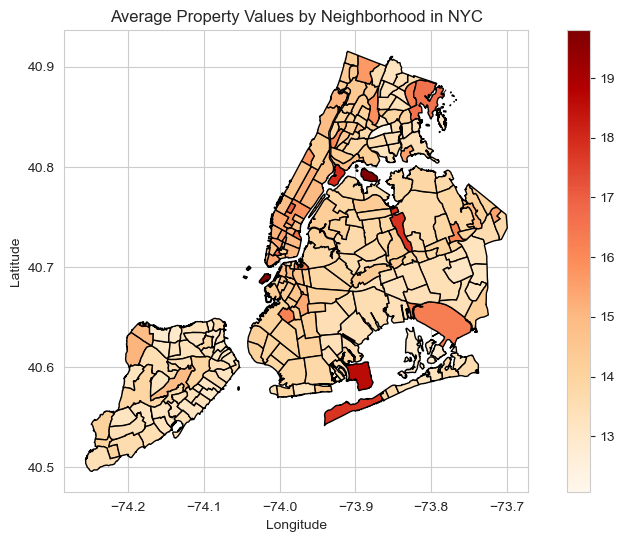

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

average_neighborhood_val.plot(
    column='log_avg_property_val',
    ax=ax,
    legend=True,
    cmap='OrRd',
    edgecolor='black',    
    vmin=average_neighborhood_val.log_avg_property_val.describe()['min'],
    vmax=average_neighborhood_val.log_avg_property_val.describe()['max'],
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "Missing values",
    })

plt.title('Average Property Values by Neighborhood in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Explore the Correlation between Crash Rate and Average Property Value

After plotting Number of Crashes against Average property value, there seems to be a negative trend. That is to say, areas with lower property value would have higher collision exposure. However, the data seem to be extremely right skewed. Look at the Histogram for more detail.

In [14]:
average_neighborhood_val.head(10)

,neighborhood,avg_property_val,geometry,log_avg_property_val,text,count_of_crashes
84,East New York,7.386944e+05,"POLYGON ((-73.86132 40.67502, -73.86107 40.674...",13.512640,"East New York:738,694",12590
101,Flushing,8.839702e+05,"POLYGON ((-73.79276 40.77401, -73.79272 40.773...",13.692179,"Flushing:883,970",12332
138,Jamaica,6.917030e+05,"POLYGON ((-73.77582 40.70538, -73.77592 40.704...",13.446912,"Jamaica:691,703",11763
15,Bedford-Stuyvesant,1.028228e+06,"POLYGON ((-73.94115 40.70028, -73.90548 40.680...",13.843348,"Bedford-Stuyvesant:1,028,228",10334
262,Williamsburg,9.151622e+05,"POLYGON ((-73.95757 40.7251, -73.953 40.72225,...",13.726857,"Williamsburg:915,162",10081
71,Crown Heights,1.164166e+06,"POLYGON ((-73.96333 40.67556, -73.96439 40.681...",13.967516,"Crown Heights:1,164,166",10040
125,Harlem,1.608382e+06,"POLYGON ((-73.93457 40.82815, -73.93442 40.827...",14.290740,"Harlem:1,608,382",9941
81,East Flatbush,6.998624e+05,"POLYGON ((-73.90842 40.6506, -73.91375 40.6471...",13.458639,"East Flatbush:699,862",9687
42,Bushwick,9.717130e+05,"POLYGON ((-73.90582 40.69411, -73.90158 40.691...",13.786816,"Bushwick:971,713",9474
248,Upper East Side,3.205273e+06,"POLYGON ((-73.94359 40.78275, -73.94365 40.782...",14.980308,"Upper East Side:3,205,273",9137


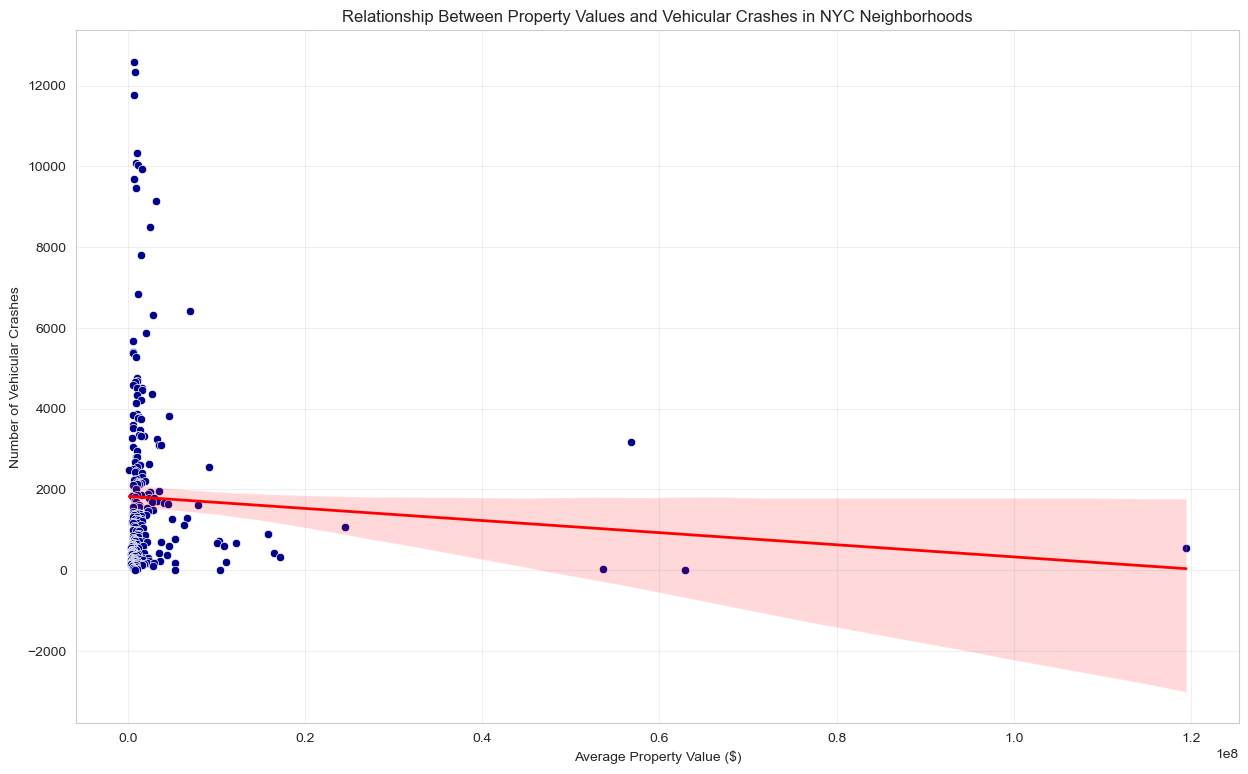

In [22]:
# df_val_st_50M=average_neighborhood_val[average_neighborhood_val['avg_property_val']<50000000]
plt.figure(figsize=(15, 9))

# Create the scatter plot
sns.scatterplot(data=average_neighborhood_val, 
                x="avg_property_val", 
                y="count_of_crashes", 
                color='Darkblue')

# Add a trend line using regplot
sns.regplot(data=average_neighborhood_val, 
            x="avg_property_val", 
            y="count_of_crashes", 
            scatter=False,  # Do not draw the scatter points again
            color='red',   # Change color if desired
            line_kws={'linewidth': 2})  # Customize line properties

plt.title("Relationship Between Property Values and Vehicular Crashes in NYC Neighborhoods")
plt.xlabel("Average Property Value ($)")
plt.ylabel("Number of Vehicular Crashes")
plt.grid(alpha=0.3)
plt.show()

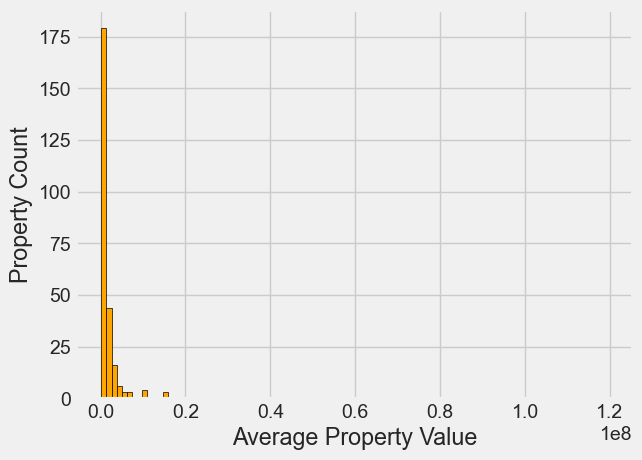

In [29]:
bins = np.linspace(average_neighborhood_val.avg_property_val.min(), average_neighborhood_val.avg_property_val.max(), num=100)
plt.hist(average_neighborhood_val.avg_property_val, bins=bins,color='Orange', edgecolor = 'black')
plt.style.use('fivethirtyeight')
plt.xlabel('Average Property Value')
plt.ylabel('Property Count')
plt.show()


However, we want to acknowledge the limitation that we cannot confidently reach the conclusion that neighborhoods with lower average property value have more crashes happen. To more properly analyze this question, it requires further knowledge to "normalize" the property data. This is our attempt to use Box Cox transformation for normalization. However, normalization is out of scope of this course, 

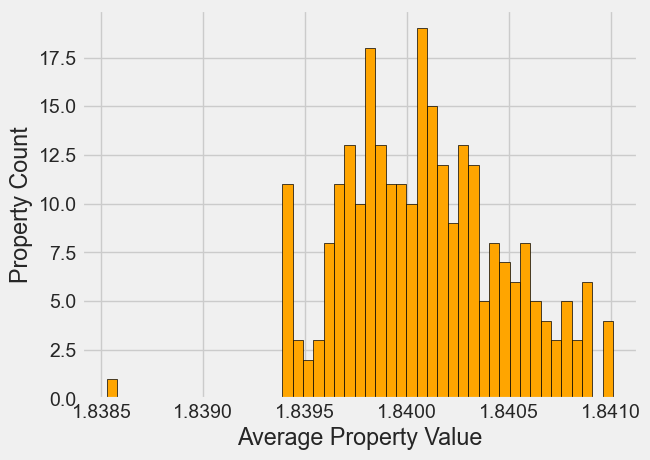

In [31]:
from scipy.stats import boxcox

average_neighborhood_val["boxcox_avg_property_val"], _ = boxcox(average_neighborhood_val['avg_property_val'])
bins = np.linspace(average_neighborhood_val.boxcox_avg_property_val.min(), average_neighborhood_val.boxcox_avg_property_val.max(), num=50)
plt.style.use('fivethirtyeight')
plt.hist(average_neighborhood_val.boxcox_avg_property_val, bins=bins,color='Orange', edgecolor = 'black')
plt.xlabel('Average Property Value')
plt.ylabel('Property Count')
plt.show()
